# Programming Assignment 1: MNIST

## MANUAL IMPLEMENTATION

Download the necessary libraries

In [34]:
# Import the libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data.dataset import TensorDataset
import tensorflow as tf # used for one hot encoding

## DATA LOADING AND DATA PREPARATION

In [35]:
# Get the training and testing datasets
# First need to transform the images into a suitable form (normalization)
# I found the normalization values around some blogs. It seems to work pretty well.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)),])

# DataLoader class
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

dataloaders = {}
# First I import the "full" dataset without dividing it into batches. I'll do it during the training of the model
dataloaders['train'] = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=True)
dataloaders['test'] = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=True)

train_features, train_labels = next(iter(dataloaders['train']))
test_features, test_labels = next(iter(dataloaders['test']))

## CHECKS

In [ ]:
# First image in matrix form 28x28, the import has worked correctly
#print(train_features[0])

In [36]:
# Shape of train images
print(train_features.shape)
# Shape of the train labels
print(train_labels.shape)
# Some labels just to check: they are not hot encoded!
print(train_labels[:10].numpy())

torch.Size([60000, 1, 28, 28])
torch.Size([60000])
[3 5 7 2 6 4 7 2 1 8]


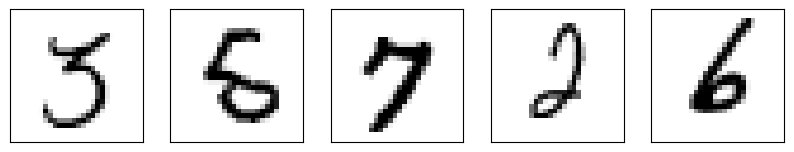

In [37]:
# Depict some pictures from the training set
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(5,5,i+1)

    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Convert the image to a format suitable for plotting
    plt.imshow(train_features[i].squeeze().numpy(), cmap=plt.cm.binary)

plt.show()

In [38]:
# Flattening
train_features = train_features.numpy()
train_labels = train_labels.numpy()
test_features = test_features.numpy()
test_labels = test_labels.numpy()

train_features_flat = train_features.reshape(train_features.shape[0],train_features.shape[1]*train_features.shape[2]*train_features.shape[3])
test_features_flat = test_features.reshape(test_features.shape[0],test_features.shape[1]*test_features.shape[2]*test_features.shape[3])

In [39]:
# Shape to check if the values are flatted
print(train_features[0].shape)
print(train_features_flat[0].shape)

(1, 28, 28)
(784,)


In [40]:
# One hot encoded
train_labels_onehot = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_labels_onehot = tf.keras.utils.to_categorical(test_labels, num_classes=10)
print('One-hot-encoded labels')
print(train_labels_onehot[0:9,:])
foo = np.argmax(train_labels_onehot,axis=1)
print('\nSanity check where one-hot-encoded are converted back to the original digits')
print(foo[0:9]) # it works: this will be useful later to "translate" the MLP output to the original labels

One-hot-encoded labels
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

Sanity check where one-hot-encoded are converted back to the original digits
[3 5 7 2 6 4 7 2 1]


In [41]:
train_features_flat_torch = torch.from_numpy(train_features_flat)
train_labels_onehot_torch = torch.from_numpy(train_labels_onehot)

test_features_flat_torch = torch.from_numpy(test_features_flat)
test_labels_onehot_torch = torch.from_numpy(test_labels_onehot)

train_dataset = TensorDataset(train_features_flat_torch,train_labels_onehot_torch)
test_dataset = TensorDataset(test_features_flat_torch,test_labels_onehot_torch)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=len(test_dataset), shuffle=True)

### HELPER FUNCTIONS
Here I implemented some general functions that will be useful during the implementation of the MLP.

In [42]:
# Activation functions for the hidden layer and their relative derivative
def sigmoid(x):
    """
    Activation function sigmoid.
    """
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(z):
    """
    Derivative of the sigmoid function.
    """
    return sigmoid(z)*(1-sigmoid(z))

def relu(z):
    """
    Activation function ReLu.
    """
    return np.maximum(0,z)

def relu_prime(z):
    """
    Derivative of the ReLu function.
    """
    return z > 0

def tanh(z):
    """
    Activation function tanh.
    """
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

def tanh_prime(z):
    """
    Derivative of the tanh function.
    """
    return 1 - tanh(z)**2

# Activation function for the output layer
def softmax(z):
    """
    Activation function softmax. Converts a vector of real numbers into a probability function.
    """
    return np.exp(z)/sum(np.exp(z))

Glorot function to initialize the parameters. NB: the functions initializes just the weights w, the biases are initialized with 0.

In [43]:
def glorot_init(No,Ni):
    """
    Glorot function. Initialization of the weights.
    The technique sets the initial weights of the network to values drawn from a uniform distribution.
    wij ∼ U[−M,M]
    It prevents the gradients from diminishing or exploding as they propagate through the network.
    The variance should remain stable.
    :param:
        Ni: number of inputs to the weight tensor.
        No: number of outputs in the weight tensor.
    :return:
        W: vector of weights initialized from the above distribution.
    """
    M = np.sqrt(6/(Ni+No))
    W = np.random.uniform(low=-M, high=M, size=(No,Ni)) # weights
    return W

In [44]:
# Cross entropy loss to compute the loss between predicted value and ground truth
def cross_entropy_loss(Y_hat, Y):
    """
    Compute the final cost using cross entropy.
    :param:
        'Y_hat': predicted values {0,1}
        'Y': ground truth {0,1}
    :return:
        cost: value of the cost function
    """
    m = Y.shape[1]

    # result is a matrix of log probabilities for each prediction
    logprobs = np.multiply(-np.log(Y_hat),Y) + np.multiply(-np.log(1 - Y_hat), 1 - Y)

    # sum and ignore NaN values (log(0) = -inf)
    cost = 1./m * np.nansum(logprobs)
    return cost

#  3 Backpropagation from Scratch

## BUILDING THE NETWORK

Architecture: I/P → h1(500) → h2(250) → h3(100) → O/P
</br>
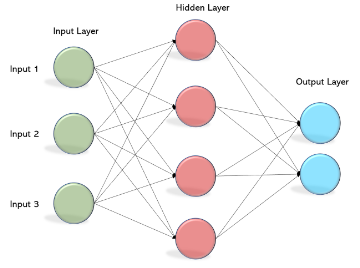

</br>
I implemented the network as a class so to resemble the library "method". More or less the idea is the same even though it is a bit more "strict" with the parameters etc.
</br>
I added the description of the function in the comment space.

In [45]:
class MyNetwork(object):

    def __init__(self, sizes):
        self.__num_layers = len(sizes) # number of layers in the network
        self.__sizes = sizes # neurons for each layer

    def get_num_layers(self):
        return self.__num_layers

    def get_sizes(self):
        return self.__sizes

    def initialize_parameters(self):
        """
        Given the sizes of each layer initialize the weights (+ biases) for every layer.
        :param:
            'sizes': contains the number of neurons in the respective layers of the network.
            For example, if the list was [3, 4, 2] then it would be a three-layer network, with the first layer
            containing 3 neurons, the second layer 4 neurons, and the third layer 2 neuron.
        :return:
            'parameters': python dictionary containing the parameters "W1", "b1", ...,"WL", "bL"
                WL: weight matrix of shape (layer_dims[l-1], layer_dims[l])
                bL: bias vector of shape (1, layer_dims[l])
        """

        np.random.seed(666)
        parameters = {}
        sizes = self.get_sizes()
        L = self.get_num_layers()

        for l in range(1, L):
            # initialize the bias with 0. Parameters with glorot initialization function.
            # W1 will be a matrix containing all the weights between input and first hidden layer, etc.
            parameters['W' + str(l)] = glorot_init(sizes[l], sizes[l-1])
            parameters['b' + str(l)] = np.zeros(shape=(sizes[l],1))

            # Verify that the dimension of the weight matrix is correct
            # Eg: figure above. For the hidden layer, I expect a matrix with 3 columns (input) and 4 rows (number of neurons in l)
            assert(parameters['W' + str(l)].shape == (sizes[l], sizes[l-1]))
            assert(parameters['b' + str(l)].shape == (sizes[l], 1))
        return parameters

    def forward_pass(self, X, parameters):
        """
        Shape of X = 28*28 = 784
        The function implements the forward propagation using vectorization to speed up the process.
        :param:
            'X': input dataset of shape (input size, number of examples)
            'parameters': python dictionary containing the parameters "W1", "b1", ...,"WL","bL"
            W1 weights between input layer and first hidden layer, etc.
                       W1: weight matrix of shape (500,784) - (output, input)
                       b1: bias vector of shape (500,1)
                       W2: weight matrix of shape (250,500)
                       b2: bias vector of shape (250,1)
                       W3: weight matrix of shape (100,250)
                       b3: bias vector of shape (100,1)
                       W4: weight matrix of shape (10,100)
                       b4: bias vector of shape (10,1)
        :return:
            'prediction': output value of the MLP (final result of the forward pass)
            'cache': dictionary containing the computation of each Z (combination of x (input to the layer) and weights)
                    and A (Z with activation function). For example cache['Z2'] will contain a 500x1 vector: i-th value
                    of the vector is the combination for the i-th neuron. Same idea for A2.
        """

        cache={}
        # Input - First hidden layer
        cache['Z2'] = np.dot(parameters['W1'],X)+parameters['b1']
        cache['A2'] = sigmoid(cache['Z2'])
        # First hl - Second hl
        cache['Z3'] = np.dot(parameters['W2'],cache['A2'])+parameters['b2']
        cache['A3'] = sigmoid(cache['Z3'])
        # Second hl - Third hl
        cache['Z4'] = np.dot(parameters['W3'],cache['A3'])+parameters['b3']
        cache['A4'] = sigmoid(cache['Z4'])
        # Third hl - Output
        cache['Z5'] = np.dot(parameters['W4'],cache['A4'])+parameters['b4']
        cache['A5'] = softmax(cache['Z5'])
        # Final activation function is the prediction itself
        prediction = cache['A5']
        # Also the weights (+ biases) are saved in the cache
        for key in parameters.keys():
            cache[key] = parameters[key]

        return prediction, cache

    def backward_pass(self, X,Y,cache):
        """
        Update of the weights (+ biases) using the chain rule of derivation.
        :param:
        'Y_hat': predicted values
        'Y': ground truth
        :return:
        cost: value of the cost function
        """

        m = X.shape[1]
        nabla = {}

        # Loss layer
        nabla['dZ5'] = cache['A5']-Y

        # Output layer
        nabla['dW4'] = 1./m * np.dot(nabla['dZ5'],cache['A4'].T)
        nabla['db4'] = 1./m * np.sum(nabla['dZ5'],axis=1,keepdims=True)

        # Third hidden layer neurons (to apply chain rule)
        nabla['dA4'] = np.dot(cache['W4'].T,nabla['dZ5'])
        nabla['dZ4'] = np.multiply(nabla['dA4'],sigmoid_prime(cache['Z4']))

        # Third hidden layer
        nabla['dW3'] = 1./m * np.dot(nabla['dZ4'],cache['A3'].T)
        nabla['db3'] = 1./m * np.sum(nabla['dZ4'],axis=1,keepdims=True)

        # Second hidden layer neurons (to apply chain rule)
        nabla['dA3'] = np.dot(cache['W3'].T,nabla['dZ4'])
        nabla['dZ3'] = np.multiply(nabla['dA3'],sigmoid_prime(cache['Z3']))

        # Second hidden layer
        nabla['dW2'] = 1./m * np.dot(nabla['dZ3'],cache['A2'].T)
        nabla['db2'] = 1./m * np.sum(nabla['dZ3'],axis=1,keepdims=True)

        # First hidden layer neurons (to apply chain rule)
        nabla['dA2'] = np.dot(cache['W2'].T,nabla['dZ3'])
        nabla['dZ2'] = np.multiply(nabla['dA2'],sigmoid_prime(cache['Z2']))

        # First hidden layer
        nabla['dW1'] = 1./m * np.dot(nabla['dZ2'],X.T)
        nabla['db1'] = 1./m * np.sum(nabla['dZ2'],axis=1,keepdims=True)
        return nabla

    def update_parameters(self,parameters,grads,lr):
        """
        Apply the updating rule for the weights (+ biases).
        Eg:
        updated_param['W1']=parameters['W1']-lr*grads['dW1']
        updated_param['b1']=parameters['b1']-lr*grads['db1']
        etc.

        :param:
        'parameters': current values of the parameters
        'grads': gradients computed during the backward pass
        'lr': learning rate
        :return:
        updated_param: updated parameters
        """

        updated_param = {}

        for key in parameters.keys():
            updated_param[key] = parameters[key]-lr*grads['d'+str(key)]

        return updated_param

    def predict(self,X,parameters):
      """
      Given the desired features, predict the labels using the weights given.

        :param:
        'parameters': current values of the parameters (usually trained with the training dataset).

        :return:
        pred_label: predicted labels using the NN and the 'parameters'
      """
      pred_label,_ = self.forward_pass(X,parameters)
      return pred_label

### ACCURACY

In [46]:
def calculate_accuracy(Y_hat_onehot, Y_onehot):
    """
    Calculating accuracy of the parameter at the output.
    :param:
    Y: ground truth in one hot encoding.
    Y_hat: prediction of the NN in one hot encoding.

    :return:
    accuracy: finding the matches of the prdicted vs the actual
    """

    Y_hat = np.argmax(Y_hat_onehot, axis = 0) # actual value (digit from 0 to 9) shape (64,)
    Y = np.argmax(Y_onehot, axis = 0) # actual value (digit from 0 to 9) shape (64,)
    test_acc = np.sum(Y_hat == Y)/Y.shape[0]
    return test_acc*100

In [47]:
# I need to use the cpu as I use Numpy for all my computations
device = 'cpu'

In [48]:
layer_dimensions = [784,500,250,100,10]
model = MyNetwork(sizes = layer_dimensions)

In [49]:
def train_model(data_loader, model, num_epochs=15, learning_rate=0.01, device='cpu'):
    """
    Train the model given the data. For num_epochs of time the model is trained, which
    means that, based on the backward propagation, the weights (params) are adjusted.
    The loss function is also saved so to understand if the model is actually learning well.
    :param:
    data_loader: torch loader of the training data (inputs and labels)
    model: desired network to be trained
    num_epochs: for how many epochs the model will be trained?
    learning_rate: learning rate used for the weights update
    device: in this case just cpu is available since I'm working with numpy

    :return:
    batch_loss: list of loss every 200 iterations (i.e 200 batch updates)
    losses: list of loss function for every epoch (in total num_epochs values)
    parameters: weights of the net for every layer trained
    train_accuracy: accuracy of the model on the training data
    test_loss: list of loss function every 200 iterations on ALL the test data
    """
    losses = []
    batch_loss = []
    test_loss = []
    train_accuracy = []

    data_iter = iter(test_loader)
    test_data = next(data_iter)
    X_test,y_test = test_data
    X_test = X_test.numpy()
    y_test = y_test.numpy()

    parameters = model.initialize_parameters()

    for epoch in range(num_epochs):
        running_loss = 0.0
        num_batches = 0

        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            X = inputs.numpy()
            y = labels.numpy()

            # print(X.shape) # (64, 784)
            # print(y.shape) # (64, 10)

            # Make the forward pass
            a5, history = model.forward_pass(X.T, parameters)

            # End of the NN: compute the loss for this batch
            cost = cross_entropy_loss(a5, y.T)

            # Make the backward pass and compute the gradients
            gradients = model.backward_pass(X.T, y.T, history)

            # Update parameters using gradients
            parameters = model.update_parameters(parameters, gradients, learning_rate)

            # Accumulate the running loss over batches
            running_loss += cost
            num_batches += 1

            if num_batches % 200 == 0:
                # Store the loss and accuracy for every 200 iterations
                batch_loss.append(cost)
                train_accuracy.append(calculate_accuracy(a5, y.T))

                # Loss for test dataset
                y_hat_test, _ = model.forward_pass(X_test.T,parameters)
                test_cost = cross_entropy_loss(y_hat_test, y_test.T)
                test_loss.append(test_cost)

        # Compute the average loss over all batches for this epoch
        epoch_loss = running_loss / num_batches
        losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    return batch_loss, losses, parameters, train_accuracy, test_loss

batch_loss,train_loss,train_params,train_accuracy,test_loss=train_model(train_loader,model,15,0.01,device=device)

Epoch [1/15], Loss: 3.2035
Epoch [2/15], Loss: 3.0137
Epoch [3/15], Loss: 2.5418
Epoch [4/15], Loss: 1.9547
Epoch [5/15], Loss: 1.5530
Epoch [6/15], Loss: 1.2817
Epoch [7/15], Loss: 1.0840
Epoch [8/15], Loss: 0.9436
Epoch [9/15], Loss: 0.8448
Epoch [10/15], Loss: 0.7737
Epoch [11/15], Loss: 0.7208
Epoch [12/15], Loss: 0.6798
Epoch [13/15], Loss: 0.6466
Epoch [14/15], Loss: 0.6196
Epoch [15/15], Loss: 0.5966


## TRAINING DATA REPORT

### Plots

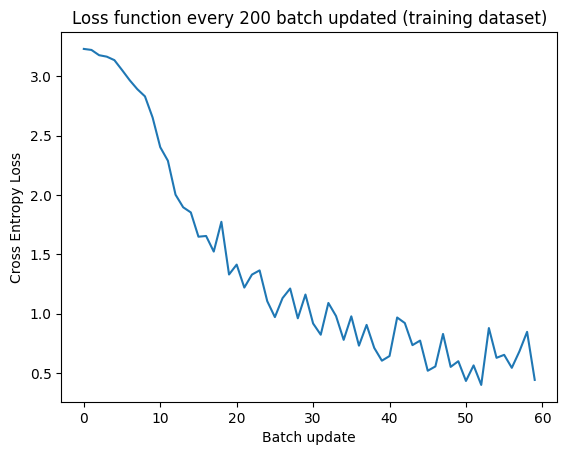

In [50]:
# Show the Loss function: I can understand if the model actually learned something
plt.plot(range(0,len(batch_loss)), batch_loss)
plt.xlabel('Batch update')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss function every 200 batch updated (training dataset)')
plt.show()

The loss function shows a decreasing pattern with some fluctuations due to the fact that the loss is computed after some iterations and not respect to the all dataset.

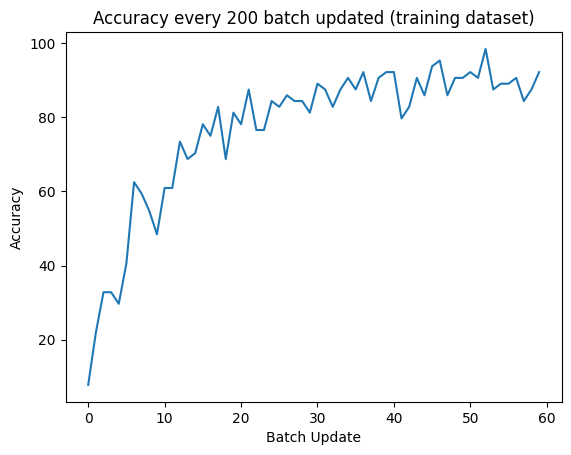

In [51]:
plt.plot(range(0,len(train_accuracy)), train_accuracy)
plt.xlabel('Batch Update')
plt.ylabel('Accuracy')
plt.title('Accuracy every 200 batch updated (training dataset)')
plt.show()

Even the accuracy shows some fluctuactions. What it is important to see is the upward trend: the model is learning correctly and it is making better and better estimations of the labels. Of course it gets close to 100% (in the below cases with other activation functions is even more clear) because we are testing the accuracy on the same data we are training the model!!


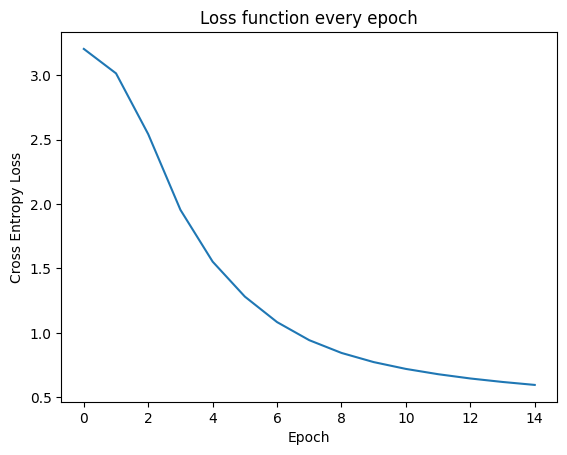

In [52]:
plt.plot(range(0,len(train_loss)), train_loss)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss function every epoch')
plt.show()

The loss function over the epochs shows a much smoother trend. What it is important to see here is that the loss keeps decreasing over the epochs and it shows positive concavity.

### Accuracy on training data

In [53]:
train_loader_acc = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=len(train_dataset), shuffle=True)
data_iter_acc = iter(train_loader_acc)
train_data_acc = next(data_iter_acc)

X_train,y_train = train_data_acc
X_train = X_train.numpy()
y_train = y_train.numpy()
y_hat_train, _ = model.forward_pass(X_train.T,train_params)
train_accuracy = calculate_accuracy(y_train.T,y_hat_train)

print(f"Accuracy on training dataset: {train_accuracy:.3f} %")

Accuracy on training dataset: 90.415 %


The accuracy is not as high as I expected, since the Net is computed on the training data without regularization, therefore I expected I kind of overfit on the data. Probably it is not that high because the epochs are just 15. I expect the accuracy to increase quite a lot as the number of epochs increases.

## TEST DATA

### Plots

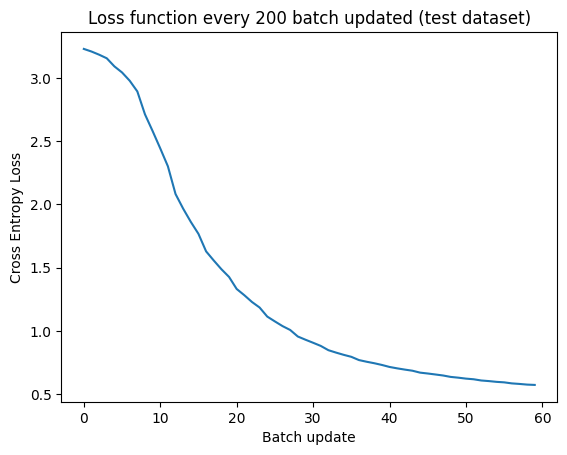

In [54]:
# Show the Loss function: I can understand if the model actually learned something
plt.plot(range(0,len(test_loss)), test_loss)
plt.xlabel('Batch update')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss function every 200 batch updated (test dataset)')
plt.show()

Even here the result is very satisfying. The loss curve shows a decreasing trend and a positive concavity during the training of the data. The loss on the test data has been computed every 200 iterations as respect to ALL the test dataset.

In [55]:
# Fetch the test data (NB: batch for test loader is the length of test dataset, therefore I fetch all the data)
data_iter = iter(test_loader)
test_data = next(data_iter)

X_test,y_test = test_data
X_test = X_test.numpy()
y_test = y_test.numpy()
y_hat_test, _ = model.forward_pass(X_test.T,train_params)
cost = cross_entropy_loss(y_hat_test, y_test.T)
test_accuracy = calculate_accuracy(y_test.T,y_hat_test)

print(f"Accuracy on test dataset: {test_accuracy:.3f} %")

Accuracy on test dataset: 90.480 %


## CONFUSION MATRIX AND CLASSIFICATION REPORT

### Confusion matrix

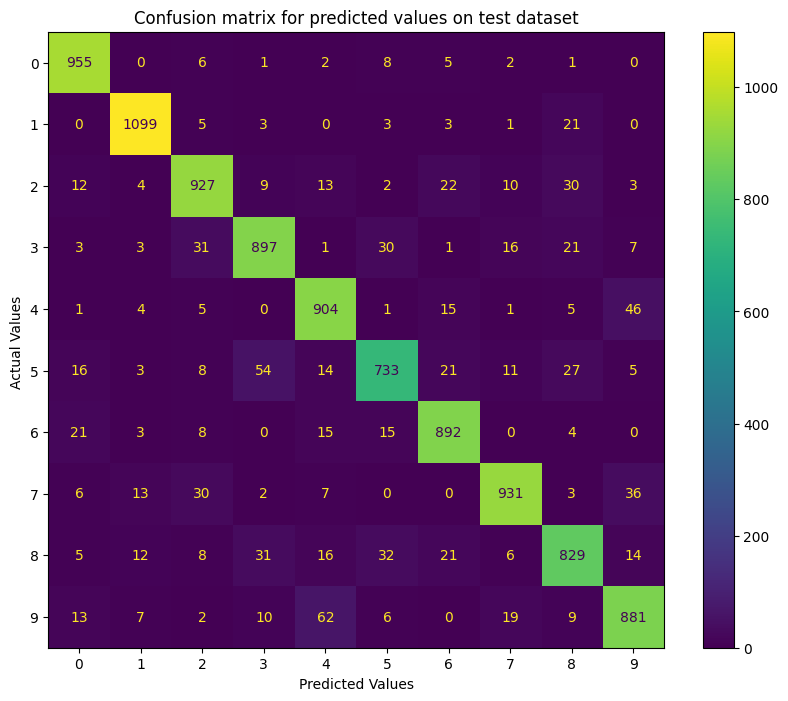

In [56]:
y_hat=np.array(np.argmax(y_hat_test,axis=0))
labels=np.array(np.argmax(y_test.T,axis=0))
from sklearn.metrics import ConfusionMatrixDisplay
# Confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(labels, y_hat, ax=ax)
ax.set_title('Confusion matrix for predicted values on test dataset')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

The confusion matrix shows good results. We can see that the number 5 is often confused with the number 3, and viceversa. The number 9 with the number 4, and viceversa. Also the 2 is confused with the 8. The first two cases are not that impressive in my opinion, since some of the digits look confusing also with the naked eye. It is therefore an inherent error in the data. A solution could be to apply some data augmentation techniques (eg: rotating the data, flipping, etc.).
</br>
The number 1, on the other side, is almost always predicted correctly.


### Classification report

In [57]:
from sklearn.metrics import classification_report

print(classification_report(labels, y_hat))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       980
           1       0.96      0.97      0.96      1135
           2       0.90      0.90      0.90      1032
           3       0.89      0.89      0.89      1010
           4       0.87      0.92      0.90       982
           5       0.88      0.82      0.85       892
           6       0.91      0.93      0.92       958
           7       0.93      0.91      0.92      1028
           8       0.87      0.85      0.86       974
           9       0.89      0.87      0.88      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



Precision is the ability of the model to correctly classify a number, eg: between the values that the Net considers 5, how many of them are actually 5?
Recall is the ability to "catch" all the samples correctly, eg: between all the 5 samples, how many of them are classified as 5 by the Net? </br>
Support is the number of samples of that digit. </br>
8,5, and 4 shows the lowest precision. 8,5, and 9 show also the lowest recall. </br>
This could be due to the similarities between the written digits (see confusion matrix above) but also the limited number of samples. For these digits, in fact, we have the lowest amount of digits (except the 9).

# 3.1 Activation

### tanh
I basically re-write the same network by changing the functions in the forward and backward pass.

In [58]:
class MyNetwork_test1(object):

    def __init__(self, sizes):
        self.__num_layers = len(sizes) # number of layers in the network
        self.__sizes = sizes # neurons for each layer

    def get_num_layers(self):
        return self.__num_layers

    def get_sizes(self):
        return self.__sizes

    def initialize_parameters(self):
        """
        Given the sizes of each layer initialize the weights (+ biases) for every layer.
        :param:
            'sizes': contains the number of neurons in the respective layers of the network.
            For example, if the list was [3, 4, 2] then it would be a three-layer network, with the first layer
            containing 3 neurons, the second layer 4 neurons, and the third layer 2 neuron.
        :return:
            'parameters': python dictionary containing the parameters "W1", "b1", ...,"WL", "bL"
                WL: weight matrix of shape (layer_dims[l-1], layer_dims[l])
                bL: bias vector of shape (1, layer_dims[l])
        """

        np.random.seed(666)
        parameters = {}
        sizes = self.get_sizes()
        L = self.get_num_layers()

        for l in range(1, L):
            # initialize the bias with 0. Parameters with glorot initialization function.
            # W1 will be a matrix containing all the weights between input and first hidden layer, etc.
            parameters['W' + str(l)] = glorot_init(sizes[l], sizes[l-1])
            parameters['b' + str(l)] = np.zeros(shape=(sizes[l],1))

            # Verify that the dimension of the weight matrix is correct
            # Eg: figure above. For the hidden layer, I expect a matrix with 3 columns (input) and 4 rows (number of neurons in l)
            assert(parameters['W' + str(l)].shape == (sizes[l], sizes[l-1]))
            assert(parameters['b' + str(l)].shape == (sizes[l], 1))
        return parameters

    def forward_pass(self, X, parameters):
        """
        Shape of X = 28*28 = 784
        The function implements the forward propagation using vectorization to speed up the process.
        :param:
            'X': input dataset of shape (input size, number of examples)
            'parameters': python dictionary containing the parameters "W1", "b1", ...,"WL","bL"
            W1 weights between input layer and first hidden layer, etc.
                       W1: weight matrix of shape (500,784) - (output, input)
                       b1: bias vector of shape (500,1)
                       W2: weight matrix of shape (250,500)
                       b2: bias vector of shape (250,1)
                       W3: weight matrix of shape (100,250)
                       b3: bias vector of shape (100,1)
                       W4: weight matrix of shape (10,100)
                       b4: bias vector of shape (10,1)
        :return:
            'prediction': output value of the MLP (final result of the forward pass)
            'cache': dictionary containing the computation of each Z (combination of x (input to the layer) and weights)
                    and A (Z with activation function). For example cache['Z2'] will contain a 500x1 vector: i-th value
                    of the vector is the combination for the i-th neuron. Same idea for A2.
        """

        cache={}
        # Input - First hidden layer
        cache['Z2']=np.dot(parameters['W1'],X)+parameters['b1']
        cache['A2']=tanh(cache['Z2'])
        # First hl - Second hl
        cache['Z3']=np.dot(parameters['W2'],cache['A2'])+parameters['b2']
        cache['A3']=tanh(cache['Z3'])
        # Second hl - Third hl
        cache['Z4']=np.dot(parameters['W3'],cache['A3'])+parameters['b3']
        cache['A4']=tanh(cache['Z4'])
        # Third hl - Output
        cache['Z5']=np.dot(parameters['W4'],cache['A4'])+parameters['b4']
        cache['A5']=softmax(cache['Z5'])
        # Final activation function is the prediction itself
        prediction=cache['A5']
        # Also the weights (+ biases) are saved in the cache
        for key in parameters.keys():
            cache[key] = parameters[key]

        return prediction, cache

    def backward_pass(self, X,Y,cache):
        """
        Update of the weights (+ biases) using the chian rule of derivation.
        :param:
        'Y_hat': predicted values
        'Y': ground truth
        :return:
        cost: value of the cost function
        """

        m=X.shape[1]
        nabla={}

        # Loss layer
        nabla['dZ5']=cache['A5']-Y

        # Output layer
        nabla['dW4']= 1./m * np.dot(nabla['dZ5'],cache['A4'].T)
        nabla['db4']= 1./m * np.sum(nabla['dZ5'],axis=1,keepdims=True)

        # Third hidden layer neurons (to apply chain rule)
        nabla['dA4']=np.dot(cache['W4'].T,nabla['dZ5'])
        nabla['dZ4']=np.multiply(nabla['dA4'],tanh_prime(cache['Z4']))

        # Third hidden layer
        nabla['dW3']=1./m * np.dot(nabla['dZ4'],cache['A3'].T)
        nabla['db3']=1./m * np.sum(nabla['dZ4'],axis=1,keepdims=True)

        # Second hidden layer neurons (to apply chain rule)
        nabla['dA3']=np.dot(cache['W3'].T,nabla['dZ4'])
        nabla['dZ3']=np.multiply(nabla['dA3'],tanh_prime(cache['Z3']))

        # Second hidden layer
        nabla['dW2']=1./m * np.dot(nabla['dZ3'],cache['A2'].T)
        nabla['db2']=1./m * np.sum(nabla['dZ3'],axis=1,keepdims=True)

        # First hidden layer neurons (to apply chain rule)
        nabla['dA2']=np.dot(cache['W2'].T,nabla['dZ3'])
        nabla['dZ2']=np.multiply(nabla['dA2'],tanh_prime(cache['Z2']))

        # First hidden layer
        nabla['dW1']=1./m * np.dot(nabla['dZ2'],X.T)
        nabla['db1']=1./m * np.sum(nabla['dZ2'],axis=1,keepdims=True)
        return nabla

    def update_parameters(self,parameters,grads,lr):
        """
        Apply the updating rule for the weights (+ biases).
        Eg:
        updated_param['W1']=parameters['W1']-lr*grads['dW1']
        updated_param['b1']=parameters['b1']-lr*grads['db1']
        etc.

        :param:
        'parameters': current values of the parameters
        'grads': gradients computed during the backward pass
        'lr': learning rate
        :return:
        updated_param: updated parameters
        """

        updated_param={}

        for key in parameters.keys():
            updated_param[key] = parameters[key]-lr*grads['d'+str(key)]

        return updated_param

    def predict(self,X,parameters):
      """
      Given the desired features, predict the labels using the weights given.

        :param:
        'parameters': current values of the parameters (usually trained with the training dataset).

        :return:
        pred_label: predicted labels using the NN and the 'parameters'
      """
      pred_label,_=self.forward_pass(X,parameters)
      return pred_label

In [59]:
model_test = MyNetwork_test1(sizes=layer_dimensions)

In [60]:
batch_loss,train_loss,train_params,train_accuracy,test_loss=train_model(train_loader,model_test,15,0.01,device=device)

Epoch [1/15], Loss: 0.7522
Epoch [2/15], Loss: 0.4097
Epoch [3/15], Loss: 0.3281
Epoch [4/15], Loss: 0.2766
Epoch [5/15], Loss: 0.2392
Epoch [6/15], Loss: 0.2102
Epoch [7/15], Loss: 0.1870
Epoch [8/15], Loss: 0.1669
Epoch [9/15], Loss: 0.1502
Epoch [10/15], Loss: 0.1358
Epoch [11/15], Loss: 0.1230
Epoch [12/15], Loss: 0.1114
Epoch [13/15], Loss: 0.1015
Epoch [14/15], Loss: 0.0921
Epoch [15/15], Loss: 0.0838


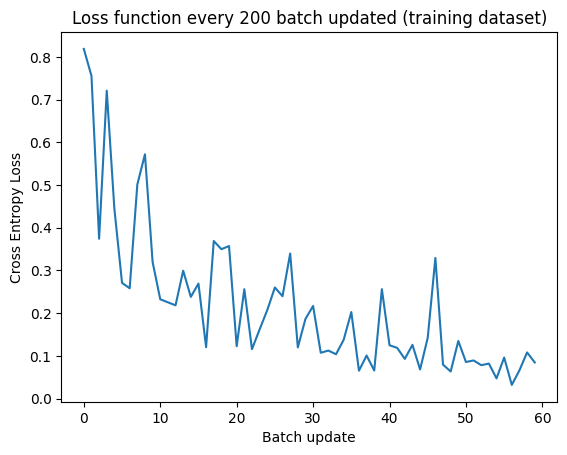

In [61]:
plt.plot(range(0,len(batch_loss)), batch_loss)
plt.xlabel('Batch update')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss function every 200 batch updated (training dataset)')
plt.show()

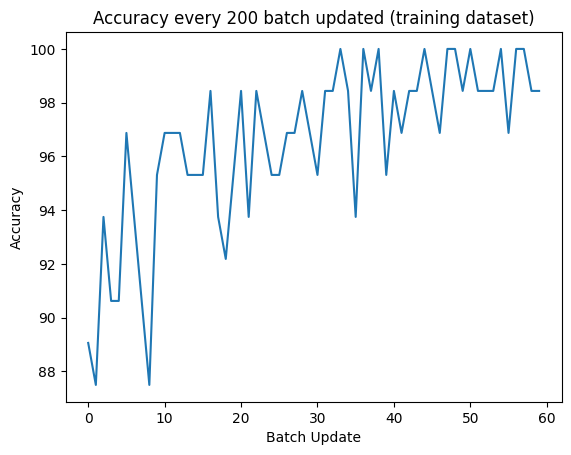

In [62]:
plt.plot(range(0,len(train_accuracy)), train_accuracy)
plt.xlabel('Batch Update')
plt.ylabel('Accuracy')
plt.title('Accuracy every 200 batch updated (training dataset)')
plt.show()

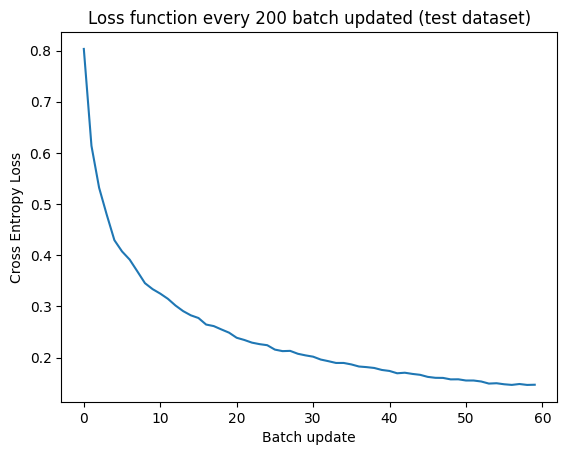

In [63]:
# Show the Loss function: I can understand if the model actually learned something
plt.plot(range(0,len(test_loss)), test_loss)
plt.xlabel('Batch update')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss function every 200 batch updated (test dataset)')
plt.show()

In [64]:
# Fetch the test data (NB: batch for test loader is the length of test dataset, therefore I fetch all the data)
data_iter = iter(test_loader)
test_data = next(data_iter)

X_test,y_test = test_data
X_test = X_test.numpy()
y_test = y_test.numpy()
y_hat_test, _ = model_test.forward_pass(X_test.T,train_params)
cost = cross_entropy_loss(y_hat_test, y_test.T)
test_accuracy = calculate_accuracy(y_test.T,y_hat_test)

print(f"Accuracy on test dataset: {test_accuracy:.3f} %")

Accuracy on test dataset: 97.520 %


In the above plots we can see similar results as for the sigmoid function. With the tanh though the accuracy of the model is much higher!

### ReLu

In [65]:
class MyNetwork_test2(object):

    def __init__(self, sizes):
        self.__num_layers = len(sizes) # number of layers in the network
        self.__sizes = sizes # neurons for each layer

    def get_num_layers(self):
        return self.__num_layers

    def get_sizes(self):
        return self.__sizes

    def initialize_parameters(self):
        """
        Given the sizes of each layer initialize the weights (+ biases) for every layer.
        :param:
            'sizes': contains the number of neurons in the respective layers of the network.
            For example, if the list was [3, 4, 2] then it would be a three-layer network, with the first layer
            containing 3 neurons, the second layer 4 neurons, and the third layer 2 neuron.
        :return:
            'parameters': python dictionary containing the parameters "W1", "b1", ...,"WL", "bL"
                WL: weight matrix of shape (layer_dims[l-1], layer_dims[l])
                bL: bias vector of shape (1, layer_dims[l])
        """

        np.random.seed(666)
        parameters = {}
        sizes = self.get_sizes()
        L = self.get_num_layers()

        for l in range(1, L):
            # initialize the bias with 0. Parameters with glorot initialization function.
            # W1 will be a matrix containing all the weights between input and first hidden layer, etc.
            parameters['W' + str(l)] = glorot_init(sizes[l], sizes[l-1])
            parameters['b' + str(l)] = np.zeros(shape=(sizes[l],1))

            # Verify that the dimension of the weight matrix is correct
            # Eg: figure above. For the hidden layer, I expect a matrix with 3 columns (input) and 4 rows (number of neurons in l)
            assert(parameters['W' + str(l)].shape == (sizes[l], sizes[l-1]))
            assert(parameters['b' + str(l)].shape == (sizes[l], 1))
        return parameters

    def forward_pass(self, X, parameters):
        """
        Shape of X = 28*28 = 784
        The function implements the forward propagation using vectorization to speed up the process.
        :param:
            'X': input dataset of shape (input size, number of examples)
            'parameters': python dictionary containing the parameters "W1", "b1", ...,"WL","bL"
            W1 weights between input layer and first hidden layer, etc.
                       W1: weight matrix of shape (500,784) - (output, input)
                       b1: bias vector of shape (500,1)
                       W2: weight matrix of shape (250,500)
                       b2: bias vector of shape (250,1)
                       W3: weight matrix of shape (100,250)
                       b3: bias vector of shape (100,1)
                       W4: weight matrix of shape (10,100)
                       b4: bias vector of shape (10,1)
        :return:
            'prediction': output value of the MLP (final result of the forward pass)
            'cache': dictionary containing the computation of each Z (combination of x (input to the layer) and weights)
                    and A (Z with activation function). For example cache['Z2'] will contain a 500x1 vector: i-th value
                    of the vector is the combination for the i-th neuron. Same idea for A2.
        """

        cache={}
        # Input - First hidden layer
        cache['Z2']=np.dot(parameters['W1'],X)+parameters['b1']
        cache['A2']=relu(cache['Z2'])
        # First hl - Second hl
        cache['Z3']=np.dot(parameters['W2'],cache['A2'])+parameters['b2']
        cache['A3']=relu(cache['Z3'])
        # Second hl - Third hl
        cache['Z4']=np.dot(parameters['W3'],cache['A3'])+parameters['b3']
        cache['A4']=relu(cache['Z4'])
        # Third hl - Output
        cache['Z5']=np.dot(parameters['W4'],cache['A4'])+parameters['b4']
        cache['A5']=softmax(cache['Z5'])
        # Final activation function is the prediction itself
        prediction=cache['A5']
        # Also the weights (+ biases) are saved in the cache
        for key in parameters.keys():
            cache[key] = parameters[key]

        return prediction, cache

    def backward_pass(self, X,Y,cache):
        """
        Update of the weights (+ biases) using the chian rule of derivation.
        :param:
        'Y_hat': predicted values
        'Y': ground truth
        :return:
        cost: value of the cost function
        """

        m=X.shape[1]
        nabla={}

        # Loss layer
        nabla['dZ5']=cache['A5']-Y

        # Output layer
        nabla['dW4']= 1./m * np.dot(nabla['dZ5'],cache['A4'].T)
        nabla['db4']= 1./m * np.sum(nabla['dZ5'],axis=1,keepdims=True)

        # Third hidden layer neurons (to apply chain rule)
        nabla['dA4']=np.dot(cache['W4'].T,nabla['dZ5'])
        nabla['dZ4']=np.multiply(nabla['dA4'],relu_prime(cache['Z4']))

        # Third hidden layer
        nabla['dW3']=1./m * np.dot(nabla['dZ4'],cache['A3'].T)
        nabla['db3']=1./m * np.sum(nabla['dZ4'],axis=1,keepdims=True)

        # Second hidden layer neurons (to apply chain rule)
        nabla['dA3']=np.dot(cache['W3'].T,nabla['dZ4'])
        nabla['dZ3']=np.multiply(nabla['dA3'],relu_prime(cache['Z3']))

        # Second hidden layer
        nabla['dW2']=1./m * np.dot(nabla['dZ3'],cache['A2'].T)
        nabla['db2']=1./m * np.sum(nabla['dZ3'],axis=1,keepdims=True)

        # First hidden layer neurons (to apply chain rule)
        nabla['dA2']=np.dot(cache['W2'].T,nabla['dZ3'])
        nabla['dZ2']=np.multiply(nabla['dA2'],relu_prime(cache['Z2']))

        # First hidden layer
        nabla['dW1']=1./m * np.dot(nabla['dZ2'],X.T)
        nabla['db1']=1./m * np.sum(nabla['dZ2'],axis=1,keepdims=True)
        return nabla

    def update_parameters(self,parameters,grads,lr):
        """
        Apply the updating rule for the weights (+ biases).
        Eg:
        updated_param['W1']=parameters['W1']-lr*grads['dW1']
        updated_param['b1']=parameters['b1']-lr*grads['db1']
        etc.

        :param:
        'parameters': current values of the parameters
        'grads': gradients computed during the backward pass
        'lr': learning rate
        :return:
        updated_param: updated parameters
        """

        updated_param={}

        for key in parameters.keys():
            updated_param[key] = parameters[key]-lr*grads['d'+str(key)]

        return updated_param

    def predict(self,X,parameters):
      """
      Given the desired features, predict the labels using the weights given.

        :param:
        'parameters': current values of the parameters (usually trained with the training dataset).

        :return:
        pred_label: predicted labels using the NN and the 'parameters'
      """
      pred_label,_=self.forward_pass(X,parameters)
      return pred_label

In [66]:
model_test2 = MyNetwork_test2(sizes=layer_dimensions)

In [67]:
batch_loss,train_loss,train_params,train_accuracy,test_loss=train_model(train_loader,model_test2,15,0.01,device=device)

Epoch [1/15], Loss: 0.6967
Epoch [2/15], Loss: 0.3331
Epoch [3/15], Loss: 0.2552
Epoch [4/15], Loss: 0.2080
Epoch [5/15], Loss: 0.1754
Epoch [6/15], Loss: 0.1502
Epoch [7/15], Loss: 0.1298
Epoch [8/15], Loss: 0.1135
Epoch [9/15], Loss: 0.0987
Epoch [10/15], Loss: 0.0880
Epoch [11/15], Loss: 0.0774
Epoch [12/15], Loss: 0.0681
Epoch [13/15], Loss: 0.0607
Epoch [14/15], Loss: 0.0542
Epoch [15/15], Loss: 0.0479


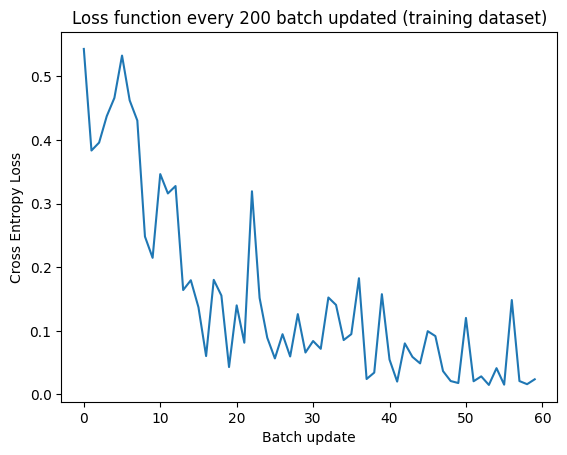

In [68]:
plt.plot(range(0,len(batch_loss)), batch_loss)
plt.xlabel('Batch update')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss function every 200 batch updated (training dataset)')
plt.show()

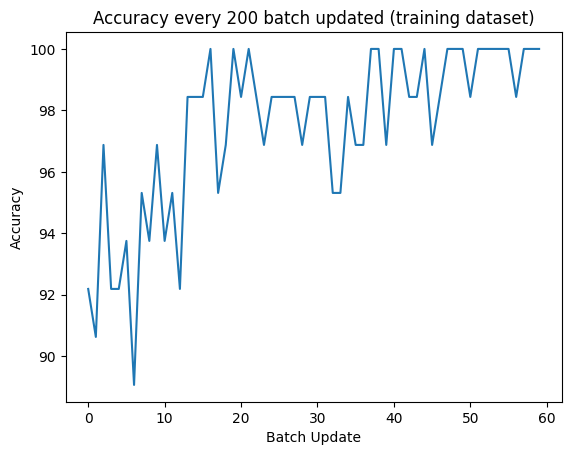

In [69]:
plt.plot(range(0,len(train_accuracy)), train_accuracy)
plt.xlabel('Batch Update')
plt.ylabel('Accuracy')
plt.title('Accuracy every 200 batch updated (training dataset)')
plt.show()

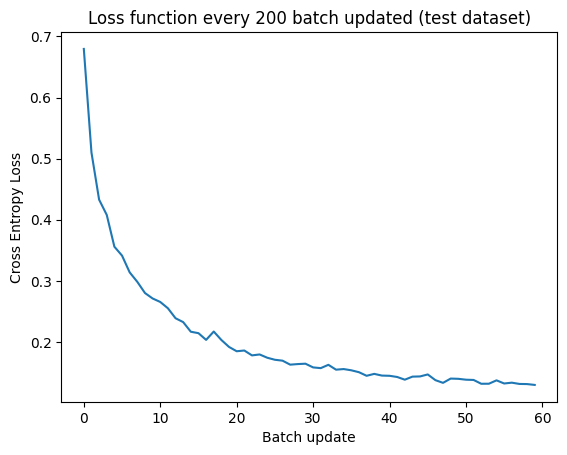

In [71]:
# Show the Loss function: I can understand if the model actually learned something
plt.plot(range(0,len(test_loss)), test_loss)
plt.xlabel('Batch update')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss function every 200 batch updated (test dataset)')
plt.show()

In [72]:
# Fetch the test data (NB: batch for test loader is the length of test dataset, therefore I fetch all the data)
data_iter = iter(test_loader)
test_data = next(data_iter)

X_test,y_test = test_data
X_test = X_test.numpy()
y_test = y_test.numpy()
y_hat_test, _ = model_test2.forward_pass(X_test.T,train_params)
cost = cross_entropy_loss(y_hat_test, y_test.T)
test_accuracy = calculate_accuracy(y_test.T,y_hat_test)

print(f"Accuracy on test dataset: {test_accuracy:.3f} %")

Accuracy on test dataset: 97.730 %


Also the ReLu function shows very good results, similar to the tanh.

## References


*   Nielsen, M. A. (2015). Neural networks and deep learning. Determination Press.
*   Mnielsen. (n.d.). neural-networks-and-deep-learning/src at master · mnielsen/neural-networks-and-deep-learning. GitHub. https://github.com/mnielsen/neural-networks-and-deep-learning/tree/master/src
*   Bishop, C. M. (1994). Neural networks for pattern recognition.
*   Kämäräinen, J.-K. (2023). Pattern recognition and machine learning [DATA.ML.200]. Tampere University. (Personal notes).
